In [156]:
%load_ext autoreload
%autoreload 2
filename = "baseline-16vCPUs-GAS-1.csv"
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
from viz import load_and_save_baseline_runs
load_and_save_baseline_runs(filename)

scanning run mav70qyp
scanning run 24nvvfn6
scanning run 1uz0w3eg
scanning run 3kvkhstd
scanning run w5lm3fh9
scanning run ounqo8gz
scanning run 3t0f6l3s
scanning run 3e6uy5ss
scanning run rkqs7wjd
scanning run 3d8sdouz
scanning run 2tp6500e
scanning run 171paxva
scanning run 48qi7v46
scanning run 35vhpwxh
scanning run 2rar2swc
scanning run 1bk3olu2
scanning run 1311psxu
scanning run 2t30yvex
scanning run 1rqpe3o1
scanning run 1b5i7osu
scanning run 2tsvil3x
scanning run 38xhcwn1
scanning run 2vtke0as
scanning run 2vool28p
scanning run tz4fvffu
scanning run 3lf2k75h
scanning run 2g7tds5j
scanning run 3jw5htq2
scanning run 5tjif3bz
scanning run 362j9n9k
scanning run 2afs5kuu
scanning run 1ss9vvqv
scanning run 2kfrudg2
scanning run xpze9d4b
scanning run 2jrj2yhk
scanning run 2i4sk2kn
scanning run 3ohne67f
scanning run 2gzlc5m7
scanning run 1s7afkc1
scanning run 1kubld5u
scanning run 39ygw6se
scanning run 2a1mswih
scanning run 1c3h0max
scanning run 1rmbvfb5
scanning run 2zrcgna9
scanning r

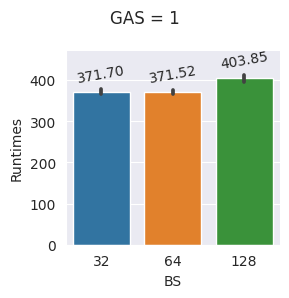

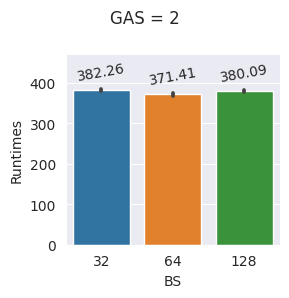

In [185]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data = pd.read_csv(os.path.abspath("") + f"/summary-{filename}")

for gas in [1, 2]:
    data_gas = data[data["gradient_accumulation_steps"] == gas]
    g = sns.FacetGrid(data_gas)
    g.figure.suptitle(f"GAS = {gas}")
    g2 = g.map_dataframe(sns.barplot, x="batch_size_per_step", y="_runtime", dodge=False, palette="tab10")

    for axlist in g2.axes:
        for ax in axlist:
            for i in ax.containers:
                ax.bar_label(i, fmt="%.2f", rotation=10, padding=5)
    plt.ylim(top=470)

    g.set_titles(col_template="LR = {col_name}")
    g.set_xlabels("BS")
    g.set_ylabels("Runtimes")

    g.figure.savefig(f"../../figures/06_barplot-runtime_gas-{gas}_{filename.replace('.csv', '.pdf')}", bbox_inches="tight")
    plt.show()

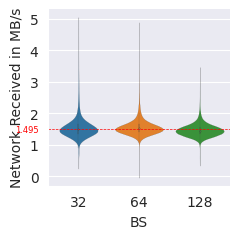

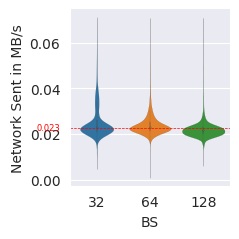

In [183]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from viz import draw_line

data = pd.read_csv(os.path.abspath('') + f"/{filename}")

limit_recv = 5
limit_sent = 0.07

data = data[data["bandwidth/net_recv_sys_bandwidth_mbs"] < limit_recv]
data = data[data["bandwidth/net_sent_sys_bandwidth_mbs"] < limit_sent]

g = sns.FacetGrid(data, margin_titles=True, height=2.5)
g.map_dataframe(sns.violinplot, x="batch_size_per_step", y="bandwidth/net_recv_sys_bandwidth_mbs", dodge=False, linewidth=0.1, palette="tab10")
ax = plt.gca()
draw_line(ax, data["bandwidth/net_recv_sys_bandwidth_mbs"].median())

g.set_xlabels("BS")
g.set_ylabels("Network Received in MB/s", clear_inner=True)
g.figure.savefig(f"../../figures/06_net-recv_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
plt.show()

g = sns.FacetGrid(data, margin_titles=True, height=2.5)
g.map_dataframe(sns.violinplot, x="batch_size_per_step", y="bandwidth/net_sent_sys_bandwidth_mbs", dodge=False, linewidth=0.1, palette="tab10")
ax = plt.gca()
draw_line(ax, data["bandwidth/net_sent_sys_bandwidth_mbs"].median())

g.set_xlabels("BS")
g.set_ylabels("Network Sent in MB/s", clear_inner=True)
g.figure.savefig(f"../../figures/06_net-sent_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
plt.show()



In [166]:
import os
import pandas as pd

data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")

to_keep = ["gradient_accumulation_steps", "max_steps", "batch_size_per_step", "optimizer_params.lr"]
data = data.sort_values(
    to_keep,
    ascending=[True, False, True, True]
)
data = data.groupby(by=to_keep)["_runtime"].describe().reset_index()

latex_output = []

for _, row in data.iterrows():
    max_steps = int(row['max_steps'])
    batch_size_per_step = int(row['batch_size_per_step'])
    lr = row['optimizer_params.lr']
    gas = int(row['gradient_accumulation_steps'])
    mean = round(row["mean"], 2)
    std = round(row["std"], 2)
    latex_output.append(f"{max_steps} & {batch_size_per_step} & {lr} & {gas} & {mean} ($\\pm {std}$) \\\\")
    latex_output.append("\\hline")

latex_output = "\n".join(latex_output)
with open(f"../../figures/06_summary-{filename.replace('.csv', '.tex')}", "w+") as f:
    f.write(latex_output)


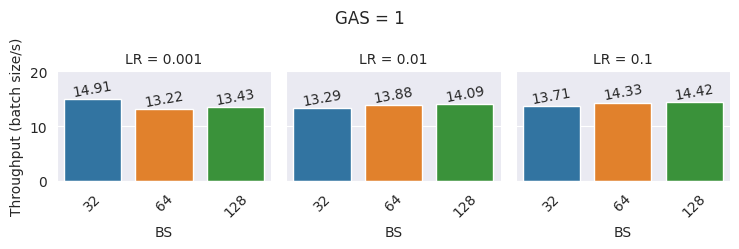

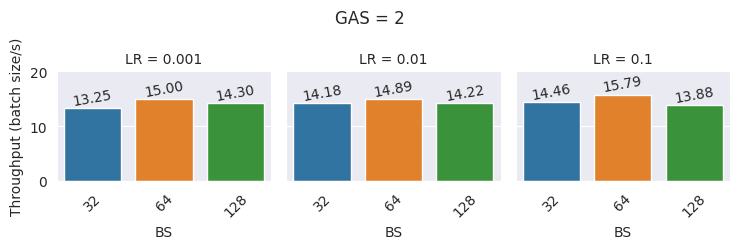

In [178]:
import pandas as pd
group_by = ["batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps"]
ascending = [True, False, True]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")

summary_data = summary_data.groupby(by=group_by)["_runtime", "train/samples_ps", "train/loss", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"].describe().reset_index()
summary_data["train/samples_ps/mean"] = summary_data["train/samples_ps"]["mean"]

summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

# temporary
for gas in [1, 2]:
    data_gas = summary_data[summary_data["gradient_accumulation_steps"] == gas]
    g = sns.FacetGrid(data_gas, col="optimizer_params.lr", height=2.5, margin_titles=True, aspect=1)
    g.figure.suptitle(f"GAS = {gas}")

    g.set_xticklabels(rotation=45)
    g2 = g.map_dataframe(sns.barplot, x="batch_size_per_step", y="train/samples_ps/mean", hue="batch_size_per_step", dodge=False, order=data_gas["batch_size_per_step"].unique(), errorbar="sd", palette="tab10")
    for axlist in g2.axes:
        for ax in axlist:
            for i in ax.containers:
                ax.bar_label(i, fmt="%.2f", rotation=10)
    plt.ylim(top=20)
    g.set_titles(col_template="LR = {col_name}")
    g.set_xlabels("BS")
    g.set_ylabels("Throughput (batch size/s)", clear_inner=True)
    g.figure.savefig(f"../../figures/06_lineplot-throughput_gas-{gas}_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
    plt.show()


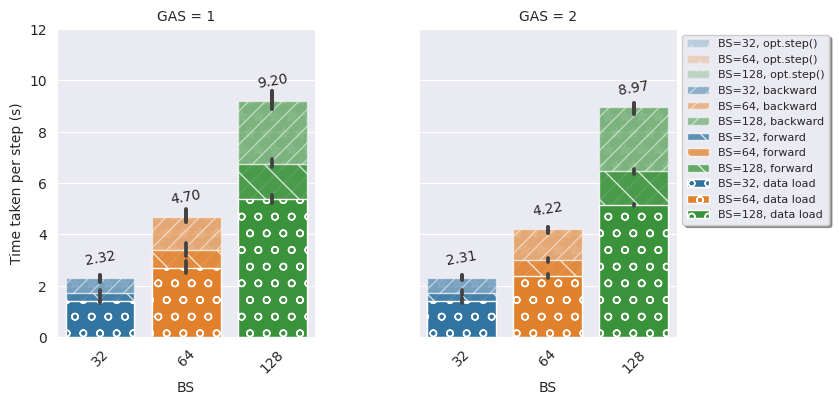

In [191]:
import itertools
import pandas as pd

group_by = ["batch_size_per_step", "optimizer_params.lr", "gradient_accumulation_steps"]
ascending = [True, True, True]

summary_data = pd.read_csv(os.path.abspath('') + f"/summary-{filename}")

summary_data = summary_data.groupby(by=group_by)["train/data_load_s", "train/model_forward_s", "train/model_backward_only_s", "train/model_opt_s"].describe().reset_index()

summary_data = summary_data.sort_values(group_by, ascending=ascending).reset_index(drop=True)

def stacked_bar(x, color, data, **kwargs):
    base_labels = data["batch_size_per_step"].unique()
    data_cumulated_column = data["train/data_load_s"]["mean"]
    data_labels = [f"BS={bs}, data load" for bs in base_labels]
    forward_cumulated_column = data_cumulated_column + data["train/model_forward_s"]["mean"]
    forward_labels = [f"BS={bs}, forward" for bs in base_labels]
    backward_cumulated_column = forward_cumulated_column + data["train/model_backward_only_s"]["mean"]
    backward_labels = [f"BS={bs}, backward" for bs in base_labels]
    opt_cumulated_column = backward_cumulated_column + data["train/model_opt_s"]["mean"]
    opt_labels = [f"BS={bs}, opt.step()" for bs in base_labels]

    sns.barplot(data, x=x, y=opt_cumulated_column, alpha=0.25, label=opt_labels, hatch="*", **kwargs)
    sns.barplot(data, x=x, y=backward_cumulated_column, alpha=0.50, label=backward_labels, hatch="//", **kwargs)
    sns.barplot(data, x=x, y=forward_cumulated_column, alpha=0.75, label=forward_labels, hatch="\\", **kwargs)
    ax = sns.barplot(data, x=x, y=data_cumulated_column, alpha=1, label=data_labels, hatch="o", **kwargs)
    for i, container in enumerate(ax.containers):
        if i % 4 == 0:
            ax.bar_label(container, fmt="%.2f", rotation=10, padding=7)

g1 = sns.FacetGrid(summary_data, col="gradient_accumulation_steps", height=4, margin_titles=True, gridspec_kws={"wspace":0.4})
# g1.figure.suptitle(f"GAS = {gas}")
g1.set_xticklabels(rotation=45)

g2 = g1.map_dataframe(
    stacked_bar,
    x="batch_size_per_step",
    dodge=False,
    order=summary_data["batch_size_per_step"].unique(),
    palette="tab10",
    linewidth=1,
)

ax = plt.gca()
ax.legend(bbox_to_anchor=(1, 1), ncol=1, fancybox=True, shadow=True, prop={"size": 8})
plt.ylim(top=12)

g1.set_titles(col_template="GAS = {col_name}")
g1.set_xlabels("BS")
g1.set_ylabels("Time taken per step (s)")
g1.tight_layout()
g1.figure.savefig(f"../../figures/06_barplot-times_{filename.replace('.csv', '.pdf')}", bbox_inches='tight')
plt.show()

